In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [4]:
csv_path = "../../results/sslvr-dataset-size.csv"

In [5]:
df = pd.read_csv(csv_path)
df.dropna(inplace=True)

In [6]:
df

,Method,Dataset,Dataset size,Top-1
0,No pretraining,UCF,1000,43.14
1,SELAVI,UCF,1000,69.18
2,RSPNET,UCF,1000,0.00
3,Video Moco,UCF,1000,65.82
4,Pretext-Contrast,UCF,1000,62.70
...,...,...,...,...
176,Pretext-Contrast,SS,Full,57.00
177,CTP,SS,Full,60.16
178,TCLR,SS,Full,59.64
179,GDT,SS,Full,57.78


### Plot for a single dataset

In [7]:
def lineplot(
        df, x, y,
        hue="Method",
        style="Method",
        figsize=(10, 8),
        title="Action classification on UCF",
        titlesize=22,
        labelsize=18,
        tickssize=14,
        palette=["lightgray", "gold", "skyblue", "green", "darkorange", "lightseagreen", "blue", "red", "black"],
        markers=["o" for _ in range(9)],
        ylim=[30, 100],
    ):
    fig, ax = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)

    sns.lineplot(
        data=df,
        x=x,
        y=y,
        hue=hue,
        style=style,
        markers=markers,
        ax=ax,
        linewidth=2.5,
        # linestyle="--",
        palette=palette,
    )

    ax.grid()
    ax.set_title(title, fontsize=titlesize)
    ax.set_ylim(*ylim)
    ax.legend(fontsize=labelsize)
    ax.yaxis.label.set_size(labelsize)
    ax.xaxis.label.set_size(labelsize)

    ax.tick_params(axis='x', labelsize=tickssize)
    ax.tick_params(axis='y', labelsize=tickssize)

    plt.savefig("../../results/plots/action_classification_ucf_datasetsize.pdf", bbox_inches="tight")
    plt.show()

In [8]:
sub_df = df[df["Dataset"] == "UCF"]

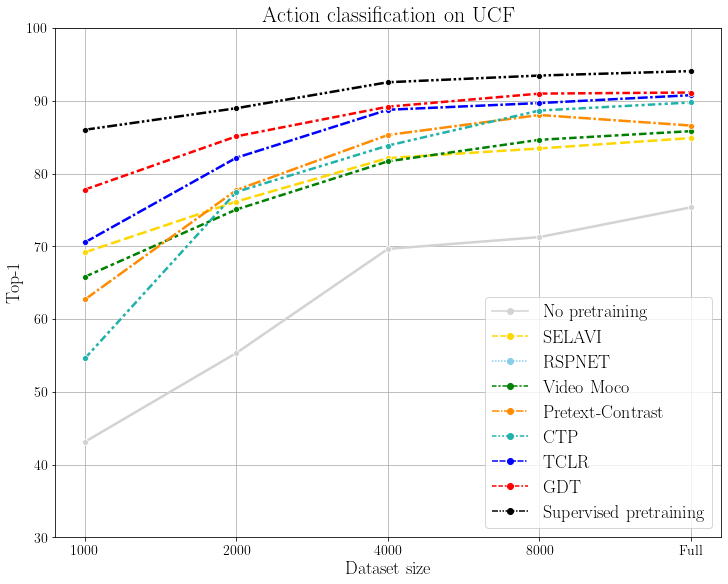

In [9]:
lineplot(sub_df, x="Dataset size", y="Top-1")

In [10]:
sub_df = df[df["Dataset"] == "NTU"]

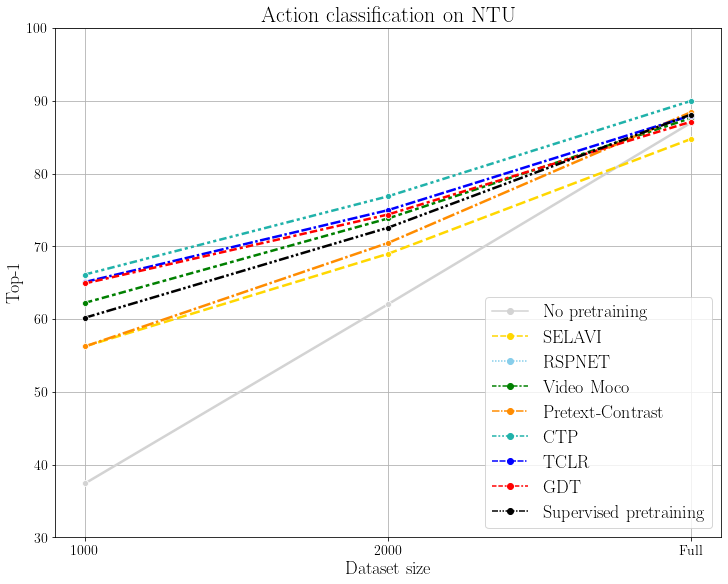

In [11]:
lineplot(sub_df, x="Dataset size", y="Top-1", title="Action classification on NTU")

In [12]:
sub_df = df[df["Dataset"] == "Gym99"]

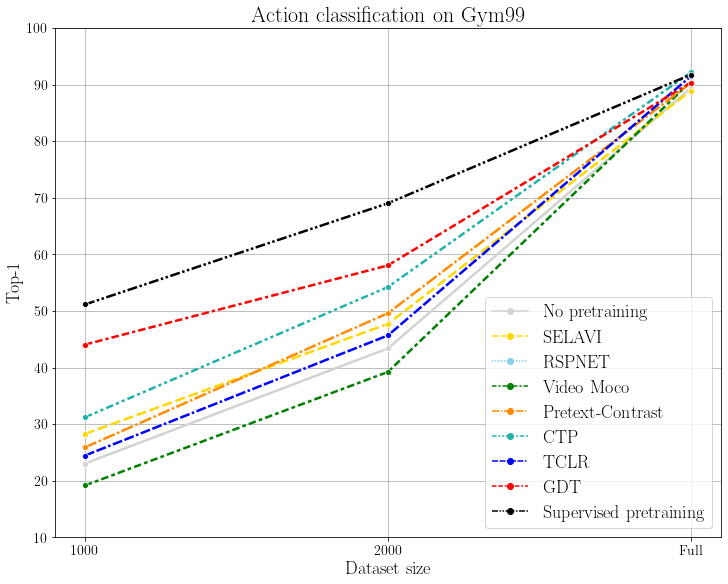

In [13]:
lineplot(sub_df, x="Dataset size", y="Top-1", title="Action classification on Gym99", ylim=[10, 100])

In [15]:
sub_df = df[df["Dataset"] == "SS"]

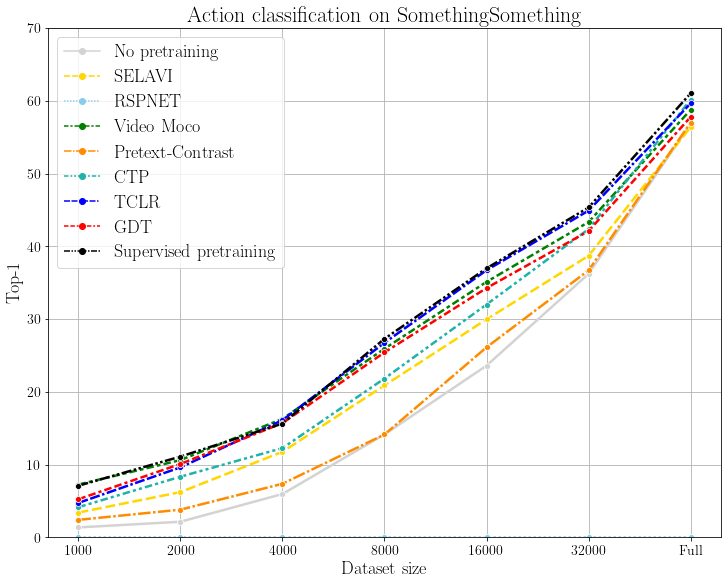

In [18]:
lineplot(sub_df, x="Dataset size", y="Top-1", title="Action classification on SomethingSomething", ylim=[0, 70])